Process_image.py - takes as input 16x16x3 matrix, corresponding to a Macroblock of the image
Outputs the result of the DCT transformation and Quantization
Inputs - M, the Macroblock
		 Q, the image compression quality, used in quanitzation
Output - B, collection of blocks followign transformation/quantization
Written by Jonathan Chamberlain - jdchambo@bu.edu

In [11]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

Definitions for 2D DCT
Functions origionally written by Mark Newman <mejn@umich.edu>
Accessed from http://www-personal.umich.edu/~mejn/computational-physics/dcst.py
Source contains blurb : "You may use, share, or modify this file freely"

In [5]:
#### 2D DCT ####
def dct2(y):
    def dct(y):
        N = len(y)
        y2 = empty(2*N,float)
        y2[:N] = y[:]
        y2[N:] = y[::-1]

        c = rfft(y2)
        phi = exp(-1j*pi*arange(N)/(2*N))
        return real(phi*c[:N])
    
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dct(y[i,:])
    for j in range(N):
        b[:,j] = dct(a[:,j])

    return b

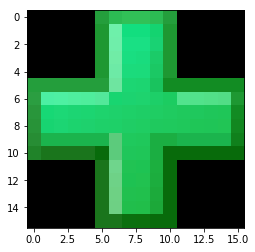

In [38]:
#Beginning of process_image
img_name = 'Add.png'
rgb = M = cv2.imread(img_name,1)
Q = 50
plt.imshow(M)

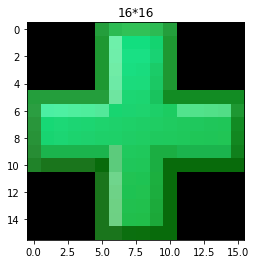

In [29]:
plt.title('16*16')
plt.imshow(M)

In [21]:
# define individual blocks B1, B2, B3, B4, S.t. M is subdivided as
# B1 | B2
# _  _ _
# B3 | B4

# These blocks will contain the Y' component of the coloration of the pixel
B1 = np.zeros(shape=(8,8))
B2 = np.zeros(shape=(8,8))
B3 = np.zeros(shape=(8,8))
B4 = np.zeros(shape=(8,8))

# We subsample the Rb, Rr components to compress data - take data from B1 block only 
Bb = np.zeros(shape=(8,8))
Br = np.zeros(shape=(8,8))
# populate B1, B2, B3, B4, Bb, Br with image data
# data in M stored as RGB, convert to Y'RbRr - use JPEG standard

In [34]:
blue,green,red = cv2.split(M)
gray = cv2.cvtColor(M , cv2.COLOR_BGR2GRAY) 

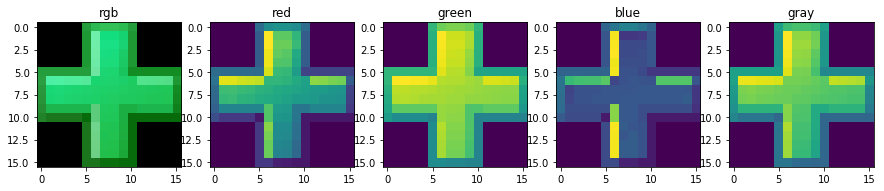

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('red')
plt.imshow(red)
plt.subplot(153)
plt.title('green')
plt.imshow(green)
plt.subplot(154)
plt.title('blue')
plt.imshow(blue)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

In [54]:
R = M[:,:,0]
G = M[:,:,1]
B = M[:,:,2]
for i in range(0,8):
    for j in range(0,8):
        B1[i,j] = (0.299*R[i,j])+(0.587*G[i,j])+(0.114*B[i,j])
        B2[i,j] = (0.299*R[i,j+8])+(0.587*G[i,j+8])+(0.114*B[i,j+8])
        B3[i,j] = (0.299*R[i+8,j])+(0.587*G[i+8,j])+(0.114*B[i+8,j])
        B4[i,j] = (0.299*R[i+8,j+8])+(0.587*G[i+8,j+8])+(0.114*B[i+8,j+8])
        Bb[i,j] = 128 - (0.168736*R[i,j]) - (0.331264*G[i,j]) + (0.5*B[i,j])
        Br[i,j] = 128 + (0.5*R[i,j]) - (0.418688*G[i,j])- (0.081312*B[i,j])
print(B1)
print(Y1)

[[   0.       0.       0.       0.       0.     110.35   132.387  137.86 ]
 [   0.       0.       0.       0.       0.     103.894  193.15   150.174]
 [   0.       0.       0.       0.       0.     103.894  192.275  154.011]
 [   0.       0.       0.       0.       0.     103.894  190.944  152.495]
 [   0.       0.       0.       0.       0.     103.894  188.873  150.762]
 [ 110.35   110.35   110.35   110.35   110.35   110.35   185.553  147.1  ]
 [ 113.013  181.599  182.67   181.339  180.524  178.557  144.975  144.997]
 [ 107.035  147.007  148.616  146.513  146.285  145.253  143.851  142.922]]
[[  0   0   0   0   0 110 132 138]
 [  0   0   0   0   0 104 193 150]
 [  0   0   0   0   0 104 192 154]
 [  0   0   0   0   0 104 191 152]
 [  0   0   0   0   0 104 189 151]
 [110 110 110 110 110 110 186 147]
 [113 182 183 181 181 179 145 145]
 [107 147 149 147 146 145 144 143]]


In [42]:
YCrCb = cv2.cvtColor(rgb , cv2.COLOR_RGB2YCR_CB) 
Y,Cb,Cr = cv2.split(YCrCb)

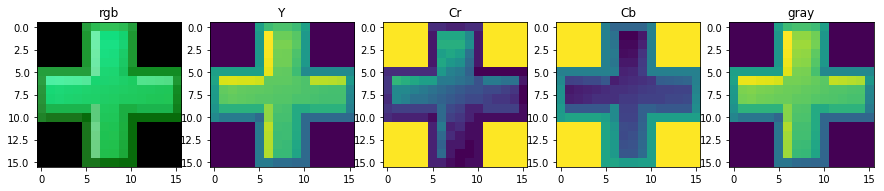

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('Y')
plt.imshow(Y)
plt.subplot(153)
plt.title('Cr')
plt.imshow(Cr)
plt.subplot(154)
plt.title('Cb')
plt.imshow(Cb)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

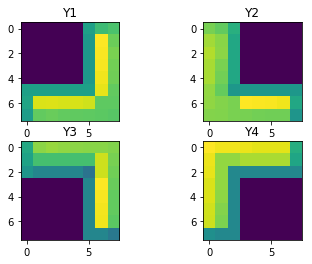

In [50]:
Y1 = Y[:8,:8]
Y2 = Y[:8,8:]
Y3 = Y[8:,:8]
Y4 = Y[8:,8:]
#plt.figure(figsize=(15,5))
plt.subplot(221)
plt.title('Y1')
plt.imshow(Y1)
plt.subplot(222)
plt.title('Y2')
plt.imshow(Y2)
plt.subplot(223)
plt.title('Y3')
plt.imshow(Y3)
plt.subplot(224)
plt.title('Y4')
plt.imshow(Y4)

In [ ]:
# for each matrix layer, run 2D DCT
# subsample layers 2,3 by only running 2D DCT on these layers for B1

# for now, Y cooresponds to R layer, Rb to B layer, Rr to G layer
print(B1)
B1 = dct2(B1) 
B2 = dct2(B2) 
B3 = dct2(B3) 
B4 = dct2(B4) 
Bb = dct2(Bb) 
Br = dct2(Br) 
print(B1)

In [ ]:
#Quantization steps for each matrix
#define base quantization matrix - taken from IJG standard 
Qb = numpy.matrix('16 11 10 16 24 40 51 61;12 12 14 19 26 58 60 55;14 13 16 24 40 57 69 56;14 17 22 29 51 87 80 62;18 22 37 56 68 109 103 77;24 35 55 64 81 104 113 92;49 64 78 87 103 121 120 101;72 92 95 98 112 100 103 99') 

# from quaity factor, determine multiplication factor for quantization
if Q < 50:
    S = 5000/Q;
else:
    S = 200 - 2*Q;

In [ ]:
# determine quantized matrix result
for i in range (0,8):
    for j in range (0,8):
        Qf = (S*Qb[i,j] + 50) // 100
        if Qf == 0:
            Qf = 1
        B1[i,j] = B1[i,j] // Qf
        B2[i,j] = B2[i,j] // Qf
        B3[i,j] = B3[i,j] // Qf
        B4[i,j] = B4[i,j] // Qf
        Bb[i,j] = Bb[i,j] // Qf
        Br[i,j] = Br[i,j] // Qf
        
# define the collection of the 6 processed blocks, and return
B = [B1, B2, B3, B4, Bb, Br]